# HW8 Group 7
- First download the MNIST dataset from http://yann.lecun.com/exdb/mnist/ and put it in a folder called MNIST on the same level as this notebook (or change the base_path under `data preparation and visualization` to the folder where you saved the dataset)

In [1]:
# Main imports
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

# General tensorflow settings
config = tf.ConfigProto()
# Use GPU in incremental mode (is ignored on CPU version)
config.gpu_options.allow_growth=True
# Add config=config in every tf.Session() -> tf.Session(config=config)

In [2]:
# Helper functions

def feed_forward_layer(x, hidden_n, activation_fn, normalize):
    initializer = tf.random_normal_initializer(stddev=0.02)
    weights = tf.get_variable("weights", [x.shape[1], hidden_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [hidden_n], tf.float32, tf.zeros_initializer())
   
    drive = tf.matmul(x, weights) + biases
    if normalize:
        drive = batch_norm(drive, [0])
   
    if activation_fn == 'linear':
        return drive
    else:
        return activation_fn(drive)


def conv_layer(x, kernels_n, kernel_size, stride_size, activation_fn, normalize):
    initializer = tf.random_normal_initializer(stddev=0.02)
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, x.shape[-1], kernels_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [kernels_n], tf.float32, tf.zeros_initializer())

    drive = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    return activation_fn(drive)


def back_conv_layer(x, target_shape, kernel_size, stride_size, activation_fn, normalize):
    initializer = tf.random_normal_initializer(stddev=0.02)
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, target_shape[-1], x.shape[-1]], tf.float32, initializer)
    biases = tf.get_variable("biases", [target_shape[-1]], tf.float32, tf.zeros_initializer())

    drive = tf.nn.conv2d_transpose(x, kernels, target_shape, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    return activation_fn(drive)


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])


def batch_norm(x, axes):
    mean, var = tf.nn.moments(x, axes = axes)
    offset_initializer = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [x.shape[-1]], tf.float32, offset_initializer)
    scale_initializer = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [x.shape[-1]], tf.float32, scale_initializer)
    return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

# Helper function to read the data
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

## Data preparation and visualization

In [3]:
tf.reset_default_graph()

In [4]:
# Read all training  data
base_path = '../hw_2/MNIST/'

# Read training data 
training_data = read_idx('{}train-images.idx3-ubyte'.format(base_path))
# Convert training data to range [-1,1]
training_data = (training_data/255) * 2 -1

# Print some information about the data
print('Training data shape: {}'.format(training_data.shape))

Training data shape: (60000, 28, 28)


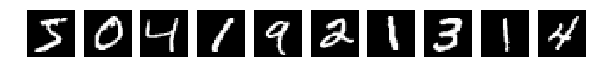

In [5]:
# Visualize the first 10 images from the training data set

# Create a figure with 10 subplots
fig, ax = plt.subplots(1, 10, figsize=(10,10))

# Loop over the 10 subplots and print the corresponding image
for i in range(10):
    # Show the image with grayscale colormap
    ax[i].imshow(training_data[i], cmap="gray")
    # Turn axis labeling off
    ax[i].axis("off")

In [6]:
training_dataset = tf.data.Dataset.from_tensor_slices((training_data))
training_dataset = training_dataset.shuffle(buffer_size=len(training_data), reshuffle_each_iteration=True)

training_batch_size = 32
training_dataset = training_dataset.batch(training_batch_size)

# First we create the iterator
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)

# We name the get_next method of the iterator to use it as a shortcut
next_batch = tf.reshape(tf.cast(iterator.get_next(), dtype=tf.float32),[-1, 28, 28, 1])

# We prepare the initializer operations for the training  dataset
training_init_op = iterator.make_initializer(training_dataset)


## Build the Model

In [7]:
kernel_size = 5
stride_size = 2

# Input generator 32 random vectors of dimension 50
generator_input = tf.placeholder(shape=[32, 50], dtype=tf.float32)
print(generator_input)

with tf.variable_scope("GENERATOR_1", reuse=tf.AUTO_REUSE) as scope:
    gen_lay_1 = tf.reshape(feed_forward_layer(generator_input, 1024, tf.nn.relu, True), [-1,4,4,64])
    print(gen_lay_1)

with tf.variable_scope("GENERATOR_2", reuse=tf.AUTO_REUSE) as scope:
    gen_lay_2 = back_conv_layer(gen_lay_1, [32, 7, 7, 32], kernel_size, stride_size, tf.nn.relu, True)
    print(gen_lay_2)

with tf.variable_scope("GENERATOR_3", reuse=tf.AUTO_REUSE) as scope:
    gen_lay_3 = back_conv_layer(gen_lay_2, [32, 14, 14, 16], kernel_size, stride_size, tf.nn.relu, True)
    print(gen_lay_3)

with tf.variable_scope("GENERATOR_4", reuse=tf.AUTO_REUSE) as scope:
    gen_lay_4 = back_conv_layer(gen_lay_3, [32, 28, 28, 1], kernel_size, stride_size, tf.tanh, False)
    print(gen_lay_4)
    
# Input discriminator 32 generated images + 32 original images
discriminator_input = tf.concat([gen_lay_4, next_batch], 0)
print(discriminator_input)

with tf.variable_scope("DISCRIMINATOR_1", reuse=tf.AUTO_REUSE) as scope:
    disc_lay_1 = conv_layer(discriminator_input, 8, kernel_size, stride_size, tf.nn.leaky_relu, True)
    print(disc_lay_1)

with tf.variable_scope("DISCRIMINATOR_2", reuse=tf.AUTO_REUSE) as scope:
    disc_lay_2 = conv_layer(disc_lay_1, 16, kernel_size, stride_size, tf.nn.leaky_relu, True)
    print(disc_lay_2)

with tf.variable_scope("DISCRIMINATOR_3", reuse=tf.AUTO_REUSE) as scope:
    disc_lay_3 = conv_layer(disc_lay_2, 32, kernel_size, stride_size, tf.nn.leaky_relu, True)
    print(disc_lay_3)
    
with tf.variable_scope("DISCRIMINATOR_4", reuse=tf.AUTO_REUSE) as scope:
    flat_disc_lay_3 = flatten(disc_lay_3)
    disc_lay_4 = feed_forward_layer(flat_disc_lay_3, 1, "linear", True)
    print(disc_lay_4)


Tensor("Placeholder:0", shape=(32, 50), dtype=float32)
Tensor("GENERATOR_1/Reshape:0", shape=(32, 4, 4, 64), dtype=float32)
Tensor("GENERATOR_2/Relu:0", shape=(32, 7, 7, 32), dtype=float32)
Tensor("GENERATOR_3/Relu:0", shape=(32, 14, 14, 16), dtype=float32)
Tensor("GENERATOR_4/Tanh:0", shape=(32, 28, 28, 1), dtype=float32)
Tensor("concat:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("DISCRIMINATOR_1/LeakyRelu:0", shape=(?, 14, 14, 8), dtype=float32)
Tensor("DISCRIMINATOR_2/LeakyRelu:0", shape=(?, 7, 7, 16), dtype=float32)
Tensor("DISCRIMINATOR_3/LeakyRelu:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("DISCRIMINATOR_4/batchnorm/add_1:0", shape=(?, 1), dtype=float32)


In [8]:
with tf.variable_scope("metrics_gen", reuse=tf.AUTO_REUSE) as scope:    
    
    cross_entropy_gen = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_lay_4[:32], labels=tf.ones(shape=(32,1)))
    print(cross_entropy_gen)
    loss_gen = tf.reduce_mean(cross_entropy_gen)
    print(loss_gen)
       
with tf.variable_scope("optimizer_gen", reuse=tf.AUTO_REUSE) as scope:
    trainable_variables = tf.trainable_variables()
    generator_variables = [var for var in trainable_variables if "GENERATOR" in var.name]
    optimizer_gen = tf.train.AdamOptimizer(learning_rate=0.0004, beta1=0.5)
    training_step_gen = optimizer_gen.minimize(loss_gen, var_list=generator_variables)
    

Tensor("metrics_gen/logistic_loss:0", shape=(32, 1), dtype=float32)
Tensor("metrics_gen/Mean:0", shape=(), dtype=float32)


In [9]:
with tf.variable_scope("metrics_disc", reuse=tf.AUTO_REUSE) as scope:    
    
    cross_entropy_disc = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_lay_4, labels=tf.concat([tf.zeros(shape=(32,1)), tf.ones(shape=(32,1))], 0))
    print(cross_entropy_disc)
    loss_disc = tf.reduce_mean(cross_entropy_disc)
    print(loss_disc)
       
with tf.variable_scope("optimizer_disc", reuse=tf.AUTO_REUSE) as scope:
    trainable_variables = tf.trainable_variables()
    discriminator_variables = [var for var in trainable_variables if "DISCRIMINATOR" in var.name]
    optimizer_disc = tf.train.AdamOptimizer(learning_rate=0.0004, beta1=0.5)
    training_step_disc = optimizer_disc.minimize(loss_disc, var_list=discriminator_variables)

Tensor("metrics_disc/logistic_loss:0", shape=(64, 1), dtype=float32)
Tensor("metrics_disc/Mean:0", shape=(), dtype=float32)


## Training and Generating Images

In [10]:
# Monitoring
discriminator_loss_summary = tf.summary.scalar("discriminator-loss",
loss_disc)
generator_loss_summary = tf.summary.scalar("generator-loss",
loss_gen)
loss_summaries = tf.summary.merge([generator_loss_summary, discriminator_loss_summary])
generated_images_summary = tf.summary.image("generated-images", gen_lay_4, max_outputs=32)
# We also have too specify summary file writers 
train_writer = tf.summary.FileWriter('./summaries/train/')

In [11]:
with tf.Session(config=config) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    step = 0
    visu_rands = np.random.uniform(size=(32,50))
    train_writer.add_graph(sess.graph)
    
    for epoch in range(2):
          
        # Load the dataset into the iterator.
        sess.run(training_init_op)
        

        # Go through the dataset until it's empty.
        while True:
            try:
                if (step % 100 == 0):
                    # use visu_rands
                    summary_images = sess.run([generated_images_summary], feed_dict={generator_input : visu_rands})
                    
                    # write summary
                    train_writer.add_summary(summary_images[0], global_step = step)

                else:
                    # Get new rands 
                    feed_rands = np.random.uniform(size=(32,50))

                    # Train
                    summaries, _, _ = sess.run([loss_summaries, training_step_disc, training_step_gen], feed_dict={generator_input : feed_rands})
                    
                    # write summary
                    train_writer.add_summary(summaries, global_step = step)
                
                step += 1
               

            # Stop if iterator is empty.
            except tf.errors.OutOfRangeError:
                break